# Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [2]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline
from scipy.interpolate import splrep
from six import StringIO
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [4]:
default_seed = 1
output_file = "output_sample"

In [5]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [122]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [25]:
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,outcome,cr_hist,train
45,164190449,15000.0,15000.0,60 months,23.05,D,7 years,MORTGAGE,63800.0,Source Verified,...,2020-02-01,2.037003,60,0.001793,0.052807,0.562917,1.800454,False,183.987351,True
114,163396715,12000.0,12000.0,36 months,7.56,A,10+ years,RENT,80000.0,Not Verified,...,2020-01-01,1.018501,36,0.000217,0.007670,0.565392,1.823593,False,129.941067,True
129,164160069,18825.0,18825.0,36 months,6.46,A,< 1 year,OWN,95000.0,Source Verified,...,2020-01-01,1.018501,36,0.000730,0.025803,0.566569,1.826705,False,87.985380,False
155,164174325,9075.0,9075.0,36 months,6.46,A,5 years,MORTGAGE,94000.0,Not Verified,...,2020-01-01,1.018501,36,0.000179,0.006337,0.565306,1.823364,False,177.942052,True
213,164107998,6000.0,6000.0,36 months,16.95,C,5 years,MORTGAGE,83200.0,Source Verified,...,2020-01-01,1.018501,36,0.005237,0.185114,0.576912,1.854049,False,135.986365,False


In [7]:
data['loan_status'].value_counts()

Fully Paid                                             924497
Charged Off                                            238525
Late (31-120 days)                                      34057
In Grace Period                                         20628
Late (16-30 days)                                        9323
Does not meet the credit policy. Status:Fully Paid       1346
Default                                                   937
Does not meet the credit policy. Status:Charged Off       498
Name: loan_status, dtype: int64

In [123]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise

def conditions(s):
    if (s['loan_status'] == 'Charged Off') or (s['loan_status'] == 'Default'):
        return True
    else:
        return False
    
data['outcome'] = data.apply(conditions, axis=1)

In [124]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [125]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice(a=[False, True], size=(len(data),), p=[0.3,0.7])

# 0.7?????


In [126]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [127]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [128]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [129]:
## define your set of features to use in different models
your_features = discrete_features + continuous_features
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train

array([[  6000.,   6000.,  43000., ...,      0.,      0.,      0.],
       [  6000.,   6000.,  50000., ...,      0.,      0.,      0.],
       [ 10000.,  10000.,  85000., ...,      0.,      0.,      0.],
       ...,
       [ 13000.,  13000.,  53000., ...,      0.,      0.,      0.],
       [  6000.,   6000.,  48000., ...,      0.,      0.,      0.],
       [ 35000.,  35000., 124000., ...,      0.,      0.,      0.]])

  Model: GaussianNB
Fit time: 0.25 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8066
              precision    recall  f1-score   support

  No default     0.8066    1.0000    0.8929     16132
     Default     0.0000    0.0000    0.0000      3868

    accuracy                         0.8066     20000
   macro avg     0.4033    0.5000    0.4465     20000
weighted avg     0.6506    0.8066    0.7203     20000



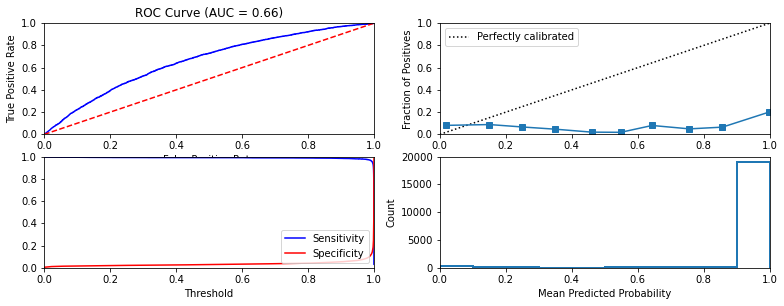


Similarity to LC grade ranking:  0.6259199179220504
Brier score: 0.7732797743990004
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.23243333]


In [26]:
## Train and test a naive bayes classifier
gnb = fit_classification(GaussianNB(),data_dict, model_name='GaussianNB' )

### $l_1$ regularized logistic regression

  Model: Lasso
Fit time: 2.45 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.4756906896675911
Accuracy:  0.80575
              precision    recall  f1-score   support

  No default     0.8104    0.9909    0.8917     16132
     Default     0.4691    0.0334    0.0623      3868

    accuracy                         0.8057     20000
   macro avg     0.6398    0.5122    0.4770     20000
weighted avg     0.7444    0.8057    0.7313     20000



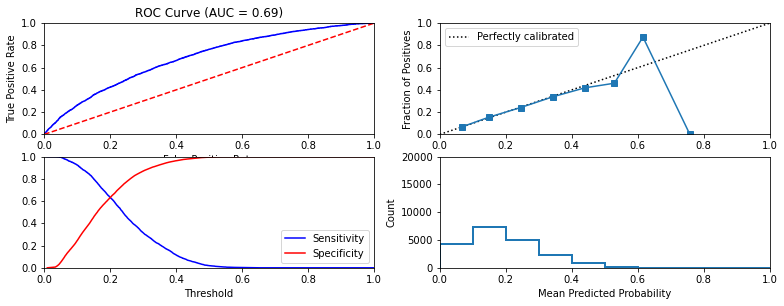


Similarity to LC grade ranking:  0.7546280681905266
Brier score: 0.14537708551781417
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80733333]


In [29]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = fit_classification(LogisticRegression(),data_dict, model_name='Lasso')

# l1_logistic = fit_classification(...)

### $l_2$ regularized logistic regression

In [33]:
## Train and test a l_2 regularized logistic regression classifier
cv_parameters = {}
Ridge = RidgeClassifier()
l2_logistic = fit_classification(Ridge, data_dict, model_name='RidgeClassifier',cv_parameters=cv_parameters)

  Model: RidgeClassifier
Fit time: 0.23 seconds
Optimal parameters:
{}

Accuracy:  0.80725
              precision    recall  f1-score   support

  No default     0.8075    0.9993    0.8932     16132
     Default     0.6857    0.0062    0.0123      3868

    accuracy                         0.8073     20000
   macro avg     0.7466    0.5028    0.4528     20000
weighted avg     0.7839    0.8073    0.7228     20000


Similarity to LC grade ranking:  0.7379959040405413


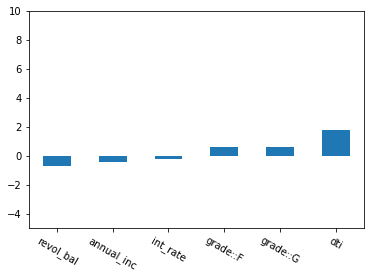

In [34]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: DecisionTreeClassifier
Fit time: 8.67 seconds
Optimal parameters:
{'min_samples_leaf': 16}

Accuracy-maximizing threshold was: 0.5161290322580645
Accuracy:  0.77405
              precision    recall  f1-score   support

  No default     0.8228    0.9174    0.8676     16132
     Default     0.3383    0.1761    0.2316      3868

    accuracy                         0.7741     20000
   macro avg     0.5806    0.5467    0.5496     20000
weighted avg     0.7291    0.7741    0.7446     20000



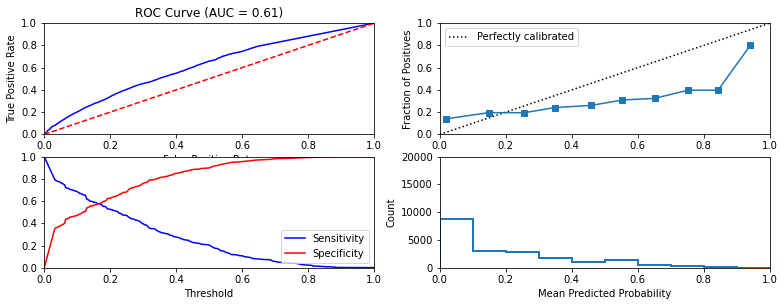


Similarity to LC grade ranking:  0.34286221405898515
Brier score: 0.17292679913471223
Were parameters on edge? : True
Score variations around CV search grid : 9.019556827544356
[0.69936667 0.72006667 0.73116667 0.74286667 0.7687    ]


In [35]:
## Train and test a decision tree classifier

cv_parameters = {"min_samples_leaf": [1, 2, 4, 8, 16]}
decision_tree = fit_classification(DecisionTreeClassifier(), data_dict, model_name='DecisionTreeClassifier',cv_parameters=cv_parameters)

### Random forest

  Model: RandomForestClassifier
Fit time: 98.79 seconds
Optimal parameters:
{'min_samples_leaf': 4}

Accuracy-maximizing threshold was: 0.31697460115583614
Accuracy:  0.7718
              precision    recall  f1-score   support

  No default     0.8384    0.8884    0.8626     16132
     Default     0.3802    0.2857    0.3262      3868

    accuracy                         0.7718     20000
   macro avg     0.6093    0.5870    0.5944     20000
weighted avg     0.7498    0.7718    0.7589     20000



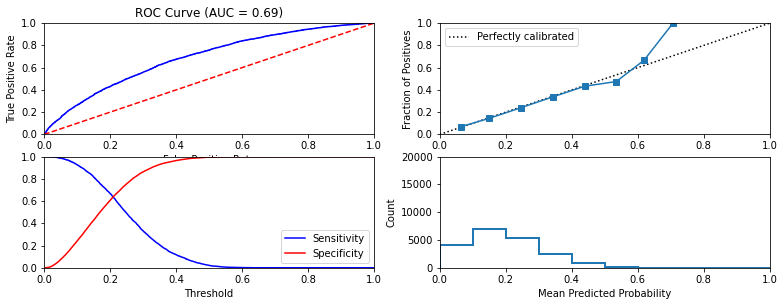


Similarity to LC grade ranking:  0.5586827846574923
Brier score: 0.14503117732384477
Were parameters on edge? : False
Score variations around CV search grid : 0.10321621733205585
[0.80653333 0.8068     0.80736667 0.80716667 0.80713333]


In [140]:
## Train and test a random forest classifier

cv_parameters = {"min_samples_leaf": [1, 2, 4, 8, 16]}
random_forest = fit_classification(RandomForestClassifier(), data_dict, model_name='RandomForestClassifier', cv_parameters=cv_parameters)

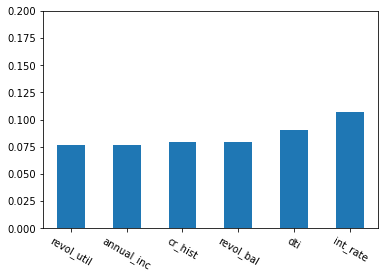

In [37]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: MLPClassifier
Fit time: 341.5 seconds
Optimal parameters:
{'activation': 'identity'}

Accuracy-maximizing threshold was: 0.4254226530730596
Accuracy:  0.8058
              precision    recall  f1-score   support

  No default     0.8110    0.9899    0.8916     16132
     Default     0.4742    0.0380    0.0704      3868

    accuracy                         0.8058     20000
   macro avg     0.6426    0.5139    0.4810     20000
weighted avg     0.7459    0.8058    0.7328     20000



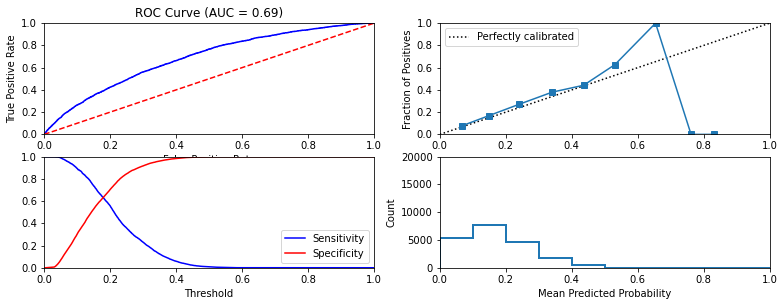


Similarity to LC grade ranking:  0.7398662456319232
Brier score: 0.14582964704381438
Were parameters on edge? : True
Score variations around CV search grid : 2.117472241713791
[0.80756667 0.80716667 0.80226667 0.79046667]


In [39]:
## Train and test a multi-layer perceptron classifier

cv_parameters={"activation":['identity', 'logistic', 'tanh', 'relu']}
mlp = fit_classification(MLPClassifier(),  data_dict, model_name='MLPClassifier', cv_parameters=cv_parameters)

## Train and Test logistic regression model with features derived by LendingClub

In [52]:
df_vif = pd.DataFrame(all_features, columns=['columns'])
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
df_vif['vif'] = vif
df_vif

,columns,vif
0,loan_amnt,2.289539e+03
1,funded_amnt,2.282890e+03
2,annual_inc,2.695188e+00
3,dti,3.522468e+00
4,delinq_2yrs,1.207311e+00
5,open_acc,6.701800e+00
6,pub_rec,1.240995e+00
7,fico_range_high,8.686522e+07
8,fico_range_low,8.621692e+07
9,revol_bal,2.132763e+00


In [54]:
df_vif[df_vif['vif']>5].sort_values(by=['vif'], ascending=False)


,columns,vif
7,fico_range_high,8.686522e+07
8,fico_range_low,8.621692e+07
0,loan_amnt,2.289539e+03
1,funded_amnt,2.282890e+03
39,home_ownership::MORTGAGE,8.167667e+02
43,home_ownership::RENT,6.532508e+02
42,home_ownership::OWN,1.754937e+02
10,int_rate,8.557043e+01
26,purpose::debt_consolidation,5.294247e+01
25,purpose::credit_card,2.039429e+01


  Model: Lasso_only_feature
Fit time: 0.13 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8066
              precision    recall  f1-score   support

  No default     0.8066    1.0000    0.8929     16132
     Default     0.0000    0.0000    0.0000      3868

    accuracy                         0.8066     20000
   macro avg     0.4033    0.5000    0.4465     20000
weighted avg     0.6506    0.8066    0.7203     20000



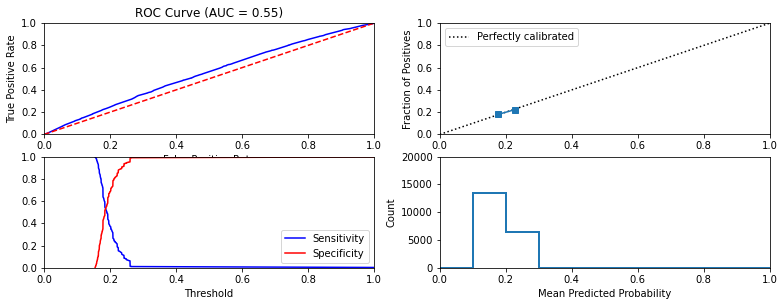


Similarity to LC grade ranking:  0.0886319076386323
Brier score: 0.15540165595499203
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.8072]


In [55]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['loan_amnt']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)

lc1_only_logistic = fit_classification(LogisticRegression(),data_dict, model_name='Lasso_only_feature')

In [56]:
## train a l2-regularized logistic regression model on data with only that feature
Ridge = RidgeClassifier()
lc2_only_logistic = fit_classification(Ridge, data_dict, model_name='RidgeClassifier_only_feature')

  Model: RidgeClassifier_only_feature
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy:  0.8066
              precision    recall  f1-score   support

  No default     0.8066    1.0000    0.8929     16132
     Default     0.0000    0.0000    0.0000      3868

    accuracy                         0.8066     20000
   macro avg     0.4033    0.5000    0.4465     20000
weighted avg     0.6506    0.8066    0.7203     20000


Similarity to LC grade ranking:  0.0886319076386323


## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [58]:
removed_features =['loan_amnt', 'fico_range_low']
selected_features = [i for i in all_features if i not in removed_features]

  Model: GaussianNB_rm_vif
Fit time: 0.06 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8066
              precision    recall  f1-score   support

  No default     0.8066    1.0000    0.8929     16132
     Default     0.0000    0.0000    0.0000      3868

    accuracy                         0.8066     20000
   macro avg     0.4033    0.5000    0.4465     20000
weighted avg     0.6506    0.8066    0.7203     20000



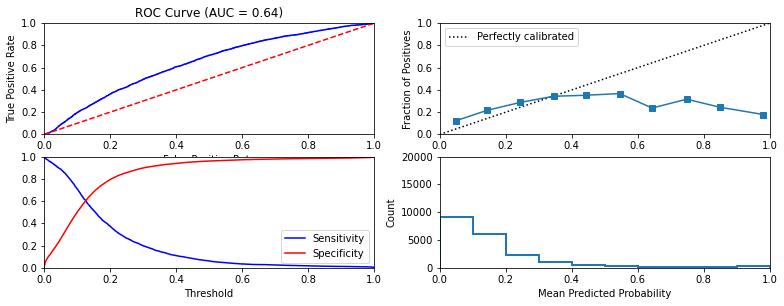


Similarity to LC grade ranking:  0.5815734574374575
Brier score: 0.16700673693014892
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.78643333]
  Model: Lasso_rm_vif
Fit time: 0.66 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8066
              precision    recall  f1-score   support

  No default     0.8066    1.0000    0.8929     16132
     Default     0.0000    0.0000    0.0000      3868

    accuracy                         0.8066     20000
   macro avg     0.4033    0.5000    0.4465     20000
weighted avg     0.6506    0.8066    0.7203     20000



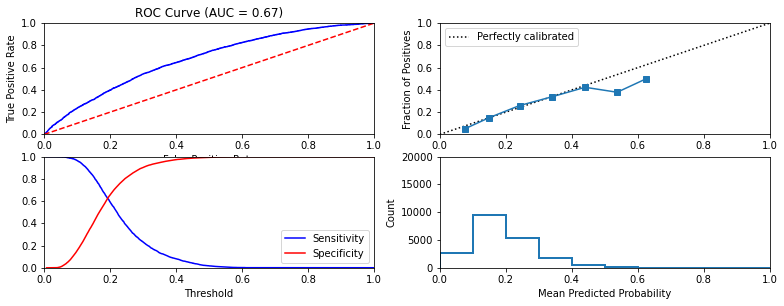


Similarity to LC grade ranking:  0.7759039791575361
Brier score: 0.14744788509855714
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80546667]
  Model: RidgeClassifier_rm_vif
Fit time: 0.09 seconds
Optimal parameters:
{}

Accuracy:  0.80645
              precision    recall  f1-score   support

  No default     0.8069    0.9992    0.8928     16132
     Default     0.4348    0.0026    0.0051      3868

    accuracy                         0.8065     20000
   macro avg     0.6208    0.5009    0.4490     20000
weighted avg     0.7349    0.8065    0.7211     20000


Similarity to LC grade ranking:  0.793680994963325
  Model: DecisionTreeClassifier_rm_vif
Fit time: 6.22 seconds
Optimal parameters:
{'min_samples_leaf': 16}

Accuracy-maximizing threshold was: 0.5172413793103449
Accuracy:  0.76965
              precision    recall  f1-score   support

  No default     0.8173    0.9202    0.8657     16132
     Default     0.2989    0.1419    0.1925      3868

 

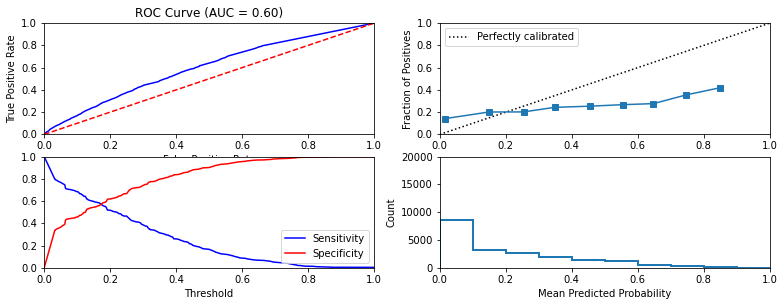


Similarity to LC grade ranking:  0.33592013998302384
Brier score: 0.17631385636736419
Were parameters on edge? : True
Score variations around CV search grid : 9.313661487574535
[0.69456667 0.71646667 0.72446667 0.7419     0.7659    ]
  Model: RandomForestClassifier_rm_vif
Fit time: 106.69 seconds
Optimal parameters:
{'min_samples_leaf': 16}

Accuracy-maximizing threshold was: 0.32580446164918087
Accuracy:  0.77665
              precision    recall  f1-score   support

  No default     0.8313    0.9071    0.8676     16132
     Default     0.3751    0.2324    0.2870      3868

    accuracy                         0.7766     20000
   macro avg     0.6032    0.5698    0.5773     20000
weighted avg     0.7431    0.7766    0.7553     20000



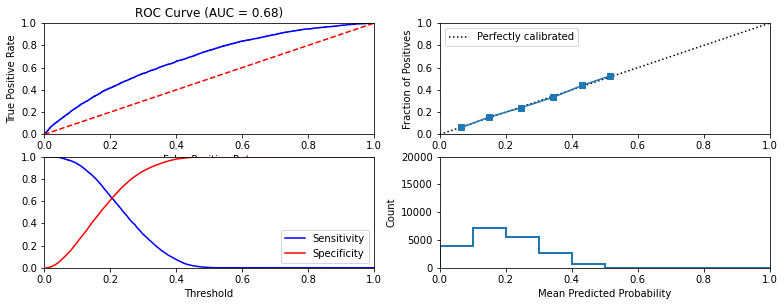


Similarity to LC grade ranking:  0.6364687044621535
Brier score: 0.1461423545098326
Were parameters on edge? : True
Score variations around CV search grid : 0.34303190610018536
[0.80383333 0.80376667 0.80516667 0.8062     0.80653333]
  Model: MLPClassifier_rm_vif
Fit time: 122.66 seconds
Optimal parameters:
{'activation': 'relu'}

Accuracy-maximizing threshold was: 0.4947011301042625
Accuracy:  0.806
              precision    recall  f1-score   support

  No default     0.8066    0.9989    0.8926     16132
     Default     0.2273    0.0013    0.0026      3868

    accuracy                         0.8060     20000
   macro avg     0.5170    0.5001    0.4476     20000
weighted avg     0.6946    0.8060    0.7204     20000



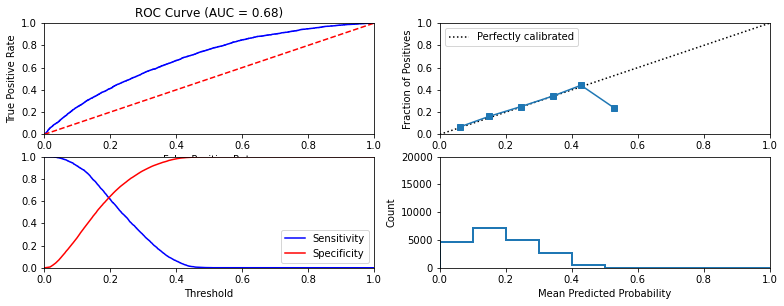


Similarity to LC grade ranking:  0.7145182735546168
Brier score: 0.14604862054273315
Were parameters on edge? : True
Score variations around CV search grid : 0.21908068783069123
[0.80463333 0.8058     0.8055     0.8064    ]


In [60]:
data_dict = prepare_data(feature_subset = selected_features)

gnb = fit_classification(GaussianNB(),data_dict, model_name='GaussianNB_rm_vif' )

l1_logistic = fit_classification(LogisticRegression(),data_dict, model_name='Lasso_rm_vif')

l2_logistic = fit_classification(RidgeClassifier(), data_dict, model_name='RidgeClassifier_rm_vif')

cv_parameters = {"min_samples_leaf": [1, 2, 4, 8, 16]}
decision_tree = fit_classification(DecisionTreeClassifier(), data_dict, model_name='DecisionTreeClassifier_rm_vif',cv_parameters=cv_parameters)

cv_parameters = {"min_samples_leaf": [1, 2, 4, 8, 16]}
random_forest = fit_classification(RandomForestClassifier(), data_dict, model_name='RandomForestClassifier_rm_vif', cv_parameters=cv_parameters)

cv_parameters={"activation":['identity', 'logistic', 'tanh', 'relu']}
mlp = fit_classification(MLPClassifier(),  data_dict, model_name='MLPClassifier_rm_vif', cv_parameters=cv_parameters)

## Time stability test of YOURMODEL

  Model: RandomForestClassifier_YOURMODEL
Fit time: 6.85 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.48
Accuracy:  0.887
              precision    recall  f1-score   support

  No default     0.8876    0.9992    0.9401      6212
     Default     0.2857    0.0025    0.0050       788

    accuracy                         0.8870      7000
   macro avg     0.5867    0.5009    0.4726      7000
weighted avg     0.8198    0.8870    0.8348      7000



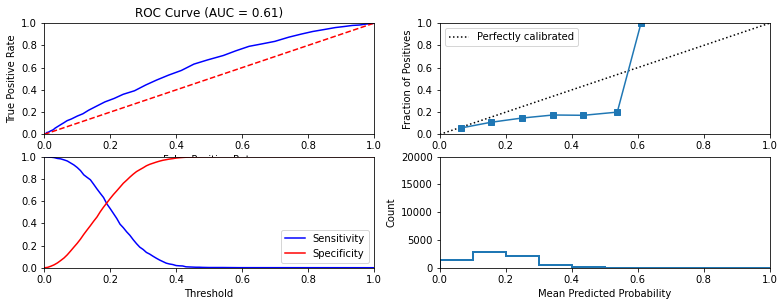


Similarity to LC grade ranking:  0.31700951727081433
Brier score: 0.10515768571428571
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.92844444]


{'model': RandomForestClassifier(),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.16, 0.22, 0.17, ..., 0.24, 0.07, 0.32])}

In [63]:
## Define the time window of your train and test data
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
# cv_parameters = ...

fit_classification(RandomForestClassifier(), data_dict_test, model_name='RandomForestClassifier_YOURMODEL')


  Model: RandomForestClassifier_YOURMODEL_2016
Fit time: 7.37 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.51
Accuracy:  0.864
              precision    recall  f1-score   support

  No default     0.8864    0.9706    0.9266      6191
     Default     0.1765    0.0482    0.0757       809

    accuracy                         0.8640      7000
   macro avg     0.5314    0.5094    0.5012      7000
weighted avg     0.8044    0.8640    0.8283      7000



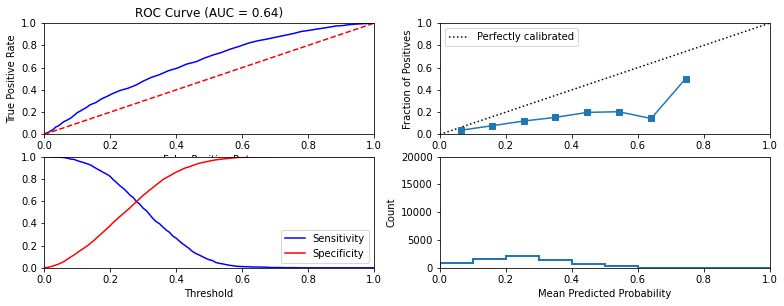


Similarity to LC grade ranking:  0.480127012836174
Brier score: 0.1261028142857143
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.76033333]


{'model': RandomForestClassifier(),
 'y_pred_labels': array([False, False, False, ..., False, False,  True]),
 'y_pred_probs': array([0.28, 0.22, 0.12, ..., 0.31, 0.31, 0.52])}

In [64]:
## Define the time window of your train and test data
start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
# cv_parameters = ...

fit_classification(RandomForestClassifier(), data_dict_test, model_name='RandomForestClassifier_YOURMODEL_2016')


## Train and test YOURMODEL on the original data

In [77]:
final_data = pd.read_csv('final_data.csv')
final_data.head()


,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,earliest_cr_line,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,revol_util,total_pymnt,recoveries,last_pymnt_d
0,164027473,20000,20000,36 months,12.40%,B,< 1 year,RENT,13000.0,Verified,...,Dec-2010,6.0,1.0,669,665,12325,59.3%,647.45,0.0,Feb-2020
1,163984413,16500,16500,60 months,10.33%,B,NaN,MORTGAGE,26000.0,Source Verified,...,Feb-2005,8.0,0.0,779,775,15000,30.9%,339.07,0.0,Feb-2020
2,164193225,7500,7500,36 months,12.40%,B,7 years,RENT,159000.0,Verified,...,Sep-1997,18.0,0.0,714,710,16195,30.7%,842.80,0.0,Feb-2020
3,162948736,19000,19000,36 months,6.46%,A,10+ years,MORTGAGE,83000.0,Verified,...,Jun-1997,7.0,0.0,789,785,11068,28.8%,1153.75,0.0,Feb-2020
4,164161686,10000,10000,36 months,20.55%,D,10+ years,MORTGAGE,110000.0,Source Verified,...,Feb-2006,14.0,0.0,769,765,4941,18.4%,357.33,0.0,Feb-2020


In [79]:
final_data['outcome'] = final_data.apply(conditions, axis=1)

In [93]:
def preprocess_data(data):
    X_continuous = data[continuous_features].values
    X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
    discrete_features_dummies = X_discrete.columns.tolist()
    X_discrete = X_discrete.values

    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
    cols = continuous_features + discrete_features_dummies
    return X, cols

preprocessed_final_data, cols = preprocess_data(final_data)

In [94]:
df_final_data = pd.DataFrame(preprocessed_final_data, columns=cols)


,loan_amnt,funded_amnt,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,...,verification_status::Source Verified,verification_status::Verified,verification_status::nan,grade::B,grade::C,grade::D,grade::E,grade::F,grade::G,grade::nan
0,20000,20000,13000.0,79.59,0.0,6.0,1.0,669,665,12325,...,0,1,0,1,0,0,0,0,0,0
1,16500,16500,26000.0,46.17,0.0,8.0,0.0,779,775,15000,...,1,0,0,1,0,0,0,0,0,0
2,7500,7500,159000.0,5.83,0.0,18.0,0.0,714,710,16195,...,0,1,0,1,0,0,0,0,0,0
3,19000,19000,83000.0,20.68,0.0,7.0,0.0,789,785,11068,...,0,1,0,0,0,0,0,0,0,0
4,10000,10000,110000.0,23.58,0.0,14.0,0.0,769,765,4941,...,1,0,0,0,0,1,0,0,0,0


In [104]:
df_final_data[continuous_features].head()

,loan_amnt,funded_amnt,annual_inc,dti,delinq_2yrs,open_acc,pub_rec,fico_range_high,fico_range_low,revol_bal,int_rate,revol_util
0,20000,20000,13000.0,79.59,0.0,6.0,1.0,669,665,12325,12.40%,59.3%
1,16500,16500,26000.0,46.17,0.0,8.0,0.0,779,775,15000,10.33%,30.9%
2,7500,7500,159000.0,5.83,0.0,18.0,0.0,714,710,16195,12.40%,30.7%
3,19000,19000,83000.0,20.68,0.0,7.0,0.0,789,785,11068,6.46%,28.8%
4,10000,10000,110000.0,23.58,0.0,14.0,0.0,769,765,4941,20.55%,18.4%


In [113]:
X = df_final_data.drop(columns=['int_rate','revol_util','dti','delinq_2yrs','open_acc','pub_rec','annual_inc'])
y = final_data.outcome.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

  Model: RandomForestClassifier_YOURMODEL_final_data
Fit time: 178.54 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.6666666666666666
Accuracy:  0.9124997880242162
              precision    recall  f1-score   support

  No default     0.9187    0.9924    0.9541    811316
     Default     0.2418    0.0267    0.0481     73219

    accuracy                         0.9125    884535
   macro avg     0.5802    0.5096    0.5011    884535
weighted avg     0.8627    0.9125    0.8791    884535



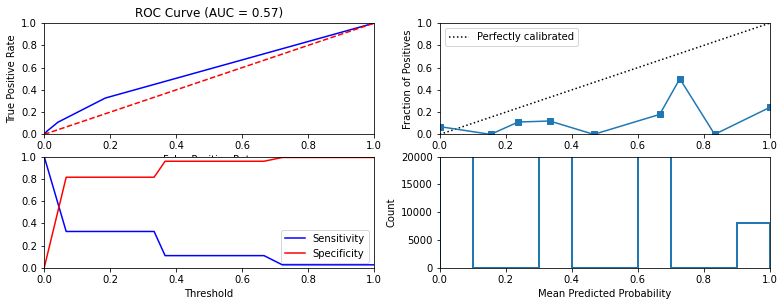

KeyError: 0

In [116]:
data_dict_final_data = {
    'X_train':np.array(X_train),
    'y_train':np.array(y_train),
    'X_test':np.array(X_test),
    'y_test':np.array(y_test),
    'train_set':np.array(0),
    'test_set':np.array(0),
}
fit_classification(RandomForestClassifier(n_estimators=3), data_dict_final_data, model_name='RandomForestClassifier_YOURMODEL_final_data')

## Test regression models

In [131]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [132]:
## First, trying l1 regularized linear regression with hyper-parameters

from sklearn import linear_model
cv_parameters = {'alpha': [i for i in np.arange(1, 10,0.5)], 
                 'fit_intercept': [True,False],
                  'selection':['random','cyclic']
                  }

reg_lasso = fit_regression(linear_model.Lasso(), data_dict, separate=False, cv_parameters=cv_parameters, model_name='Lasso Regression' )

  Model: Lasso Regression  Return column: ret_PESS
Fit time: 8.87 seconds
Optimal parameters:
{'alpha': 1.0, 'fit_intercept': False, 'selection': 'random'}

Testing r2 score: -0.0030887120338893848
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -45.98481901715195
All test scores : [-0.03393106 -0.03393106 -0.02324287 -0.02324287 -0.03393106 -0.03393106
 -0.02324287 -0.02324287 -0.03393106 -0.03393106 -0.02324287 -0.02324287
 -0.03393106 -0.03393106 -0.02324287 -0.02324287 -0.03393106 -0.03393106
 -0.02324287 -0.02324287 -0.03393106 -0.03393106 -0.02324287 -0.02324287
 -0.03393106 -0.03393106 -0.02324287 -0.02324287 -0.03393106 -0.03393106
 -0.02324287 -0.02324287 -0.03393106 -0.03393106 -0.02324287 -0.02324287
 -0.03393106 -0.03393106 -0.02324287 -0.02324287 -0.03393106 -0.03393106
 -0.02324287 -0.02324287 -0.03393106 -0.03393106 -0.02324287 -0.02324287
 -0.03393106 -0.03393106 -0.02324287 -0.02324287 -0.03393106 -0.03393106
 -0.02324287 -0.0232

### $l_2$ regularized linear regressor

In [133]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [i for i in np.arange(1, 10, 1)],  
                  }

reg_ridge = fit_regression(linear_model.Ridge(), data_dict, separate=False, cv_parameters=cv_parameters, model_name='Ridge Regression' )

  Model: Ridge Regression  Return column: ret_PESS
Fit time: 0.78 seconds
Optimal parameters:
{'alpha': 9}

Testing r2 score: 0.03992739565556169
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -9.475879040193048
All test scores : [-0.01225182 -0.01210887 -0.01198024 -0.01185046 -0.01171795 -0.01158415
 -0.01145086 -0.01131957 -0.01119134]
  Model: Ridge Regression  Return column: ret_OPT
Fit time: 0.79 seconds
Optimal parameters:
{'alpha': 5}

Testing r2 score: 0.019573913291502598
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 10.74738631565717
All test scores : [0.00219488 0.00238493 0.00244303 0.0024585  0.00245918 0.00245535
 0.00245104 0.0024478  0.00244614]
  Model: Ridge Regression  Return column: ret_INTa
Fit time: 0.76 seconds
Optimal parameters:
{'alpha': 9}

Testing r2 score: 0.038471915045781735
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 1.24155953

### Multi-layer perceptron regressor

In [134]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters={"activation":['identity', 'logistic', 'tanh', 'relu']}

reg_mlp = fit_regression(MLPRegressor(),  data_dict, model_name='Regression MLP', cv_parameters=cv_parameters)

  Model: Regression MLP  Return column: ret_PESS
Fit time: 28.9 seconds
Optimal parameters:
{'activation': 'logistic'}

Testing r2 score: 0.03468462557428964
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -293.8905615625772
All test scores : [-0.08839369 -0.02244118 -0.02626917 -0.07851522]
  Model: Regression MLP  Return column: ret_OPT
Fit time: 40.72 seconds
Optimal parameters:
{'activation': 'logistic'}

Testing r2 score: 0.0171195159266313
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 14783.137313478894
All test scores : [-0.01394335  0.00027282 -0.01582092 -0.04005883]
  Model: Regression MLP  Return column: ret_INTa
Fit time: 45.78 seconds
Optimal parameters:
{'activation': 'logistic'}

Testing r2 score: 0.03536976461468999
Were parameters on edge (model) : False
Score variations around CV search grid (model) : 179.87677736680445
All test scores : [ 0.0050092   0.0290434  -0.00450725 -0.02319893

### Random forest regressor

In [149]:
## trying random forest regression with hyper-parameters

cv_parameters = {"min_samples_leaf": [4, 8, 16]}

reg_rf = fit_regression(RandomForestRegressor(), data_dict, model_name='RandomForest Regressor', cv_parameters=cv_parameters)

  Model: RandomForest Regressor  Return column: ret_PESS
Fit time: 337.57 seconds
Optimal parameters:
{'min_samples_leaf': 16}

Testing r2 score: 0.06776517374717983
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -175.67994744645904
All test scores : [-0.01576803 -0.01175071 -0.00571969]
  Model: RandomForest Regressor  Return column: ret_OPT
Fit time: 339.23 seconds
Optimal parameters:
{'min_samples_leaf': 16}

Testing r2 score: 0.022842451077541792
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 268.3712535461419
All test scores : [-0.0081268   0.00124768  0.00482672]
  Model: RandomForest Regressor  Return column: ret_INTa
Fit time: 334.74 seconds
Optimal parameters:
{'min_samples_leaf': 16}

Testing r2 score: 0.04368482168449439
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 33.99820063408053
All test scores : [0.01905221 0.02356582 0.02886619]
  Model: RandomFo

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [142]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [150]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict=data_dict, classifier=random_forest, regressor=reg_rf, strategy=test_strategy, )

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: -0.0044072072095594815
ret_OPT: 0.03821701145389193
ret_INTa: 0.4213759338619996
ret_INTb: 1.2418377210723817


In [151]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict=data_dict, classifier=random_forest, regressor=reg_rf, strategy=test_strategy, )

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.01407978140920534
ret_OPT: 0.036873169945118245
ret_INTa: 0.4119720335339039
ret_INTb: 1.2414568782224547


In [152]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict=data_dict, classifier=random_forest, regressor=reg_rf, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.031742306487648024
ret_OPT: 0.03789462414367381
ret_INTa: 0.412244921658093
ret_INTb: 1.2406417069000104


In [154]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {"min_samples_leaf": [4, 8, 16]}
reg_separate = fit_regression(RandomForestRegressor(), data_dict, separate=True, cv_parameters=cv_parameters, model_name='RF Regression separate = TRUE' )

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict=data_dict, classifier=random_forest, regressor=reg_separate, strategy=test_strategy, )

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

  Model: RF Regression separate = TRUE  Return column: ret_PESS
Fit time: 270.1 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 16} model_1 {'min_samples_leaf': 8}

Testing r2 scores:
model_0: 0.1449693738017288
model_1: 0.14747088884806758
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -76.55128510394105
All test scores : [-0.07576786 -0.05895681 -0.04291549]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -149.19677363182453
All test scores : [-0.02327411 -0.00933965 -0.01317703]
  Model: RF Regression separate = TRUE  Return column: ret_OPT
Fit time: 235.45 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 16} model_1 {'min_samples_leaf': 16}

Testing r2 scores:
model_0: 0.16271242270641473
model_1: 0.1450840695270076
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 15.433350620440907
All test scores : [0.09838884 0.10369609 0.1163447

## Sensitivity test of portfolio size

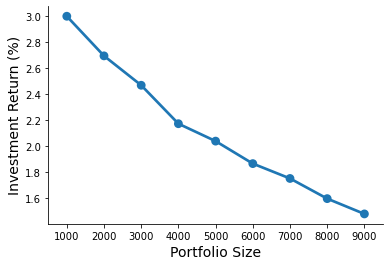

In [155]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []
test_strategy = 'Default-return-based'
## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict=data_dict, classifier=random_forest, regressor=reg_separate, strategy=test_strategy,num_loans=num_loans )
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()